# Trening modeli

Notebook obejmuje trening i wstępną walidację trzech podejść:
1) klasyczny ML (TF-IDF + Regresję logistyczną),
2) własna sieć neuronowa (MLP w PyTorch),
3) transformer (fine-tuning DistilBERT).

Wszystkie modele rozwiązują to samo zadanie: klasyfikację jakości odpowiedzi (low/mid/high).

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from collections import Counter

from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

RANDOM_SEED = 67
id2label = {0: "low", 1:"mid", 2:"high"}
label2id = {v: k for k, v in id2label.items()}
label_order = ["low", "mid", "high"]

Path("../models").mkdir(parents=True, exist_ok=True)
Path("../results").mkdir(parents=True, exist_ok=True)

# ponowne wczytanie danych, podział X/y i ustalenie baseline dla TF-IDF

W celu zapewnienia powtarzalności notatników treningowych, dokonałem ekstrakcji cech TF-IDF tutaj. Pozwala to na uproszczenie struktury i zachowanie identycznych wyników modelu bazowego.

In [92]:
#wczytanie danych
train_df = pd.read_parquet("../data/processed/train.parquet")
val_df = pd.read_parquet("../data/processed/val.parquet")
test_df = pd.read_parquet("../data/processed/test.parquet")

train_df.shape, val_df.shape, test_df.shape

# podział X/y
X_train = train_df["input_text"].astype(str)
X_val   = val_df["input_text"].astype(str)
X_test  = test_df["input_text"].astype(str)

y_train = train_df["label"].astype(int).to_numpy()
y_val   = val_df["label"].astype(int).to_numpy()
y_test  = test_df["label"].astype(int).to_numpy()

X_train.shape, y_train.shape

# TF-IDF
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape

(1818, 5496)

# Regresja logistyczna

In [93]:
lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=67
)

lr.fit(X_train_tfidf, y_train)

val_pred = lr.predict(X_val_tfidf)
print(classification_report(y_val, val_pred, target_names=["low", "mid", "high"]))

              precision    recall  f1-score   support

         low       0.41      0.48      0.44        29
         mid       0.31      0.50      0.39        34
        high       0.88      0.75      0.81       164

    accuracy                           0.68       227
   macro avg       0.54      0.58      0.55       227
weighted avg       0.74      0.68      0.70       227



Model bazowy TF-IDF i regresji logistycznej osiągnął accuracy 68% oraz macro-F1 na poziomie 0.55. Najlepsze wyniki uzyskano dla oceny „high”, za to klasa „mid” okazała się najtrudniejsza do rozróżnienia. Wskazuje to na jej  niejednoznaczność semantyczną. 

Wyniki stanowić będą punkt odniesienia dla bardziej złożonych modeli neuronowych.

# MLP w pytorch na TF-IDF

In [94]:
# klasa konwertuje TFID ze sparse na pojedyncza probke dense

class TfidfDataset(Dataset):
    def __init__(self, X_sparse, y):
        self.X = X_sparse
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.X[index].toarray().ravel().astype(np.float32)
        return torch.from_numpy(x), torch.tensor(self.y[index])

In [95]:
train_ds = TfidfDataset(X_train_tfidf, y_train)
val_ds = TfidfDataset(X_val_tfidf, y_val)
test_ds = TfidfDataset(X_test_tfidf, y_test)

len(train_ds), len(val_ds), len(test_ds)

(1818, 227, 228)

# Dataloadery
stała określi rozmiar batchu dla każdego zestawu

In [96]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Ustalenie wagi klas
Dataset zawiera dużo ocen `"high"`, mało `low i mid`. Ustawiam tutaj wagi klas w lossie

In [97]:
counts = Counter(y_train.tolist())
counts

Counter({2: 1311, 1: 274, 0: 233})

In [98]:
num_class = 3
total = sum(counts.values())
class_weights = torch.tensor(
    [total / counts[i] for i in range (num_class)],
    dtype=torch.float32
)
class_weights

tensor([7.8026, 6.6350, 1.3867])

# Model MLP
architektura ustawiona na Linear -> ReLU -> Dropout -> Linear

algorytm sprawdza, czy dostępny jest VRAM pod CUDA, jeżeli nie to trening odbędzie się na CPU

In [99]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout: float = 0.3, num_class: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_class)
        )

    def forward(self, x):
        return self.net(x)

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_tfidf.shape[1]

model = MLP(input_dim=input_dim, hidden_dim=256, dropout=0.3, num_class=3).to(device)
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=5496, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

## Pętla treningowa z walidacją
Klasyfikacja wieloklasowa entropii krzyżowej strat z wagami dla 3 klas, 

optymalizacja Adam `lr=1e-3`

 i early stopping.



In [101]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

"""
 funkcja przebiegu po danych, 
 model zwraca logity, 
 a loss porównuje je z prawdziwą klasą 
 """
def run_epoch(model, loader, train: bool):
    model.train(train)
    total_loss = 0.0
    all_preds = []
    all_true = []

# pętla po batch'ach
    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
    #zerowanie gradientów, aby zapobiec ich akumulacji
        if train:
            optimizer.zero_grad()

        logits = model(Xb)
        loss = criterion(logits, yb)

        if train:
            loss.backward()
            optimizer.step()
    
    # zbieranie statystyk
        total_loss += loss.item() * yb.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu().numpy()) # odcina od grafu gradientów, przenosi na CPU do łatwego liczenia metryk sklearn
        all_true.append(yb.detach().cpu().numpy())

    # zwraca etykiety i predykcje pod F1 i raporty
    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    return avg_loss, all_true, all_preds


In [102]:
EPOCHS = 20
PATIENCE = 3 # jeżeli przez 3 epochy nie ma poprawy macro-F1 program zakończy trening

best_val_f1 = -1.0
best_state = None # do przechowania najlepszych wag modelu
pat = 0

history = []

for epoch in range(1, EPOCHS + 1):
    train_loss, y_true_tr, y_pred_tr = run_epoch(model, train_loader, train=True)
    val_loss, y_true_v, y_pred_v = run_epoch(model, val_loader, train=False)

    val_macro_f1 = f1_score(y_true_v, y_pred_v, average="macro")
    history.append((epoch, train_loss, val_loss, val_macro_f1))

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_macro_f1={val_macro_f1:.4f}")


    # early stopping i zapisanie najlepszego modelu
    if val_macro_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_macro_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping.")
            break

Epoch 01 | train_loss=1.0736 | val_loss=1.0238 | val_macro_f1=0.5490
Epoch 02 | train_loss=0.8888 | val_loss=0.9048 | val_macro_f1=0.5259
Epoch 03 | train_loss=0.6371 | val_loss=0.8672 | val_macro_f1=0.5418
Epoch 04 | train_loss=0.4440 | val_loss=0.8625 | val_macro_f1=0.5541
Epoch 05 | train_loss=0.3093 | val_loss=0.9235 | val_macro_f1=0.5973
Epoch 06 | train_loss=0.2201 | val_loss=0.9622 | val_macro_f1=0.6094
Epoch 07 | train_loss=0.1648 | val_loss=1.0536 | val_macro_f1=0.5905
Epoch 08 | train_loss=0.1242 | val_loss=1.0821 | val_macro_f1=0.5928
Epoch 09 | train_loss=0.0980 | val_loss=1.1613 | val_macro_f1=0.5947
Early stopping.


Brak overfittingu, model dość szybko wyczerpuje sygnał TF-IDF, a dalsze epoki nic nie wnoszą.

# Raport walidacyjny MLP

In [103]:
# przywrócenie najlepszego stanu
model.load_state_dict(best_state)
_, y_true_v, y_pred_v = run_epoch(model, val_loader, train=False)

print(classification_report(y_true_v, y_pred_v, target_names=["low", "mid", "high"]))

              precision    recall  f1-score   support

         low       0.49      0.62      0.55        29
         mid       0.41      0.47      0.44        34
        high       0.88      0.81      0.84       164

    accuracy                           0.74       227
   macro avg       0.59      0.63      0.61       227
weighted avg       0.76      0.74      0.75       227



`low` ma lepszy recall

`mid` praktycznie nie poprawia się f1-score ~0.38, jest najbardziej problematyczną klasą

`high` jest dominujące, wysokiej jakości i bardzo stabilne


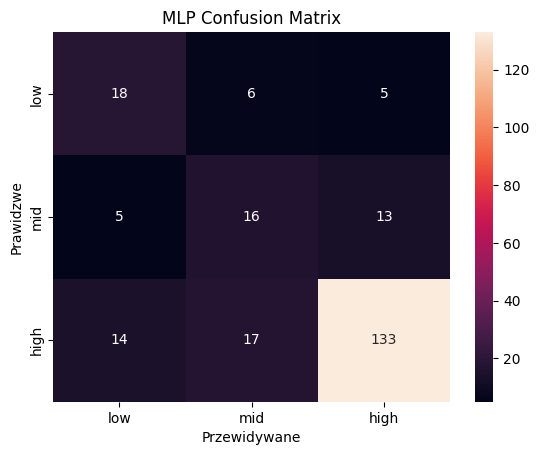

In [104]:
cm = confusion_matrix(y_true_v, y_pred_v)
cm_df = pd.DataFrame(cm, index=["low", "mid", "high"], columns=["low", "mid", "high"])

sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("MLP Confusion Matrix")
plt.xlabel("Przewidywane")
plt.ylabel("Prawidzwe")
plt.show()

In [105]:
print(type(X_train_tfidf), type(X_train_tfidf[0]))
print("typ próbki X:", type(train_ds.X[0]), "y:", train_ds[0][1].item(), ";x shape:", train_ds[0][0].shape)

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
typ próbki X: <class 'scipy.sparse._csr.csr_matrix'> y: 0 ;x shape: torch.Size([5496])


# Porównanie MLP i Regresji Logistycznej

In [106]:
def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "ważone_f1": f1_score(y_true, y_pred, average="weighted")
    }

lr_metrics = metrics(y_val, val_pred)
mlp_metrics = metrics(y_true_v, y_pred_v)

pd.DataFrame([lr_metrics, mlp_metrics], index=["Regresja log (TF-IDF)", "MLP (TF-IDF)"])

,accuracy,macro_f1,ważone_f1
Regresja log (TF-IDF),0.678414,0.547563,0.701206
MLP (TF-IDF),0.735683,0.609418,0.745424


MLP wygrywa nieznacznie: 

+4.4pp accuracy

+1,7 pp macro-F1

+2.0 pp weighted-F1

Nieliniowość pomaga głównie na granicach klas (`mid`), poprawiając separację

# Zapis wyników MLP (nmodel+predykcje)
do foldrru results|

In [107]:
torch.save(model.state_dict(), "../models/mlp_tfidf.pt")

val_out_mlp = pd.DataFrame({"y_true": y_true_v, "y_pred": y_pred_v})
val_out_mlp["y_true_name"] = val_out_mlp["y_true"].map(id2label)
val_out_mlp["y_pred_name"] = val_out_mlp["y_pred"].map(id2label)
val_out_mlp.to_csv("../results/mlp_val_predictions.csv", index=False)

Zastosowanie nieliniowej sieci neuronowej na cechach TF-IDF przynosi... umiarkowaną poprawę wyników globalnych, ale nie rozwiązuje problemu rozróżnienia klasy pośredniej (mid). Wydaje się, że ograniczeniem nie jest model klasyfikacyjny, a sama reprezentacja tekstu, która nie uwzględnia kontekstu semantycznego.

# Fine-tuning z DistilBERT (HF Transformers)

Celem jest porównywalność z regresją/MLP, z tym samym splitem i etykietami, metryki pod macroF1 i zapis danych

Trenuję na swoim GPU

In [108]:
set_seed(RANDOM_SEED)

model_name = "distilbert-base-uncased"
max_length = 128


tokenizer = AutoTokenizer.from_pretrained(model_name)

class HFDataset(torch.utils.data.Dataset):
    def __init__(self, texts: List[str], labels: np.ndarray):
      self.texts = list(texts)
      self.labels = labels.astype(int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        enc = tokenizer(
            self.texts[index],
            truncation=True,
            max_length=max_length
        )
        enc["labels"] = int(self.labels[index])
        return enc

In [109]:
X_train = train_df["input_text"].astype(str).tolist()
X_val   = val_df["input_text"].astype(str).tolist()
X_test  = test_df["input_text"].astype(str).tolist()

y_train = train_df["label"].astype(int).to_numpy()
y_val   = val_df["label"].astype(int).to_numpy()
y_test  = test_df["label"].astype(int).to_numpy()

train_ds_hf = HFDataset(X_train, y_train)
val_ds_hf   = HFDataset(X_val, y_val)
test_ds_hf  = HFDataset(X_test, y_test)

len(train_ds_hf), len(val_ds_hf), len(test_ds_hf)

(1818, 227, 228)

# Model + collator

In [110]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metryki, macro-F1 jako głowne

In [111]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return{
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted")
    }

In [ ]:
#fix na problem ze ścieżkami, wcześniej działało bez zarzutu, ale trener coś marudził i nie mógł obsłużyć ścieżki

from pathlib import Path
import os

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Argumenty treningowe dostosowane pod mój GPU

- fp16=True,

- batch 16,

- eval co epokę,

- wybór najlepszego modelu po `macro_f1`

In [113]:
training_args = TrainingArguments(
    output_dir=str(MODELS_DIR / "distilbert_runs"),
    seed=RANDOM_SEED,
    data_seed=RANDOM_SEED,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,

    fp16=True,
    logging_strategy="steps",
    logging_steps=25,

    report_to="none"
)

# Trainer + trening danych

In [114]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_hf,
    eval_dataset=val_ds_hf,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

train_result = trainer.train()
train_result

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.745400,0.719098,0.722467,0.279625,0.606059
2,0.627300,0.696068,0.740088,0.430704,0.680699
3,0.530600,0.651886,0.753304,0.518567,0.725303
4,0.448800,0.651075,0.766520,0.534872,0.736965
5,0.411500,0.650514,0.762115,0.540773,0.736709


TrainOutput(global_step=570, training_loss=0.5709194392488713, metrics={'train_runtime': 38.3599, 'train_samples_per_second': 236.966, 'train_steps_per_second': 14.859, 'total_flos': 192339366026796.0, 'train_loss': 0.5709194392488713, 'epoch': 5.0})

Przy Model poprawiał się do 5 epoki.

Zastosowanie modelu transformerowego poprawia wyniki globalne (accuracy, weighted-F1), ale nie prowadzi do istotnej poprawy macro-F1 względem modeli TF-IDF. 
Wygląda na to, że głównym ograniczeniem jest nie tyle reprezentacja semantyczna, a niejednoznaczność klasy pośredniej (mid) oraz niewielka liczebność danych.

# Ewaluacja na VAL + raport klas

In [115]:
val_pred = trainer.predict(val_ds_hf)
val_logits = val_pred.predictions
val_preds = np.argmax(val_logits, axis=1)

print("DistilBERT (VAL) metrics:", val_pred.metrics)
print(classification_report(y_val, val_preds, target_names=["low", "mid", "high"]))

DistilBERT (VAL) metrics: {'test_loss': 0.6505136489868164, 'test_accuracy': 0.762114537444934, 'test_macro_f1': 0.5407734878999247, 'test_weighted_f1': 0.7367091182372968, 'test_runtime': 0.1597, 'test_samples_per_second': 1421.762, 'test_steps_per_second': 50.106}
              precision    recall  f1-score   support

         low       0.56      0.31      0.40        29
         mid       0.42      0.29      0.34        34
        high       0.82      0.94      0.88       164

    accuracy                           0.76       227
   macro avg       0.60      0.51      0.54       227
weighted avg       0.73      0.76      0.74       227



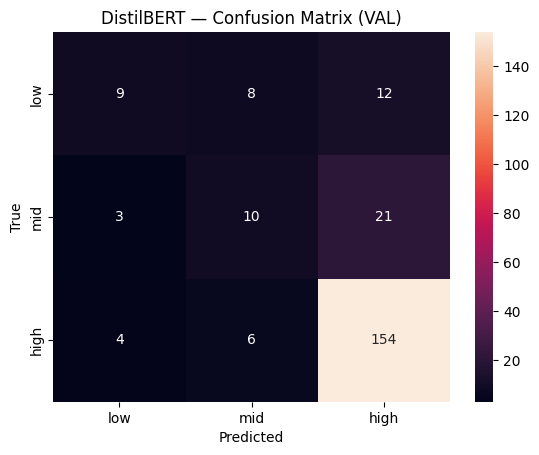

In [116]:
cm = confusion_matrix(y_val, val_preds)
cm_df = pd.DataFrame(cm, index=["low","mid","high"], columns=["low","mid","high"])

sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("DistilBERT — Confusion Matrix (VAL)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Zapis modelu i predykcji

In [117]:
trainer.save_model("../models/distilbert_tuned")
tokenizer.save_pretrained("../models/distilbert_tuned")

val_out_bert = pd.DataFrame({"y_true": y_val, "y_pred": val_preds})
val_out_bert["y_true_name"] = val_out_bert["y_true"].map(id2label)
val_out_bert["y_pred_name"] = val_out_bert["y_pred"].map(id2label)
val_out_bert.to_csv("../results/distilbert_val_predictions.csv", index=False)

val_out_bert.head()

,y_true,y_pred,y_true_name,y_pred_name
0,1,2,mid,high
1,2,2,high,high
2,2,2,high,high
3,0,0,low,low
4,2,2,high,high
